In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
from load_data import *

множественную регрессию посмотреть между d18O и температурой лета, впд лета и осадками лета для Yak, Tay. Для канады тоже спмое +весна. и написать сколько процентов во вклад дает каждый параметр

Чокурдах -- якутия

Хатанга -- таймыр

Инувик -- канада

In [3]:
def get_summer_df(df, name=''):
    return df[['Year', 'June', 'July', 'August']].rename(columns={'June':f'{name}_June', 'July':f'{name}_July', 'August':f'{name}_August'})

def get_spring_df(df, name=''):
    return df[['Year', 'March', 'April', 'May']].rename(columns={'March':f'{name}_March', 'April':f'{name}_April', 'May':f'{name}_May'})
    

In [4]:
YAK = d18O_yearly[['Year', 'd18O_YAK']].merge(
    get_summer_df(mean_temp_C, 'Temp'), on='Year', how='left').merge(
        get_summer_df(mean_prec_C, 'Prec'), on='Year', how='left').merge(
            get_summer_df(mean_vpd_C, 'VPD'), on='Year', how='left')
TAY = d18O_yearly[['Year', 'd18O_TAY']].merge(
    get_summer_df(mean_temp_H, 'Temp'), on='Year', how='left').merge(
        get_summer_df(mean_prec_H, 'Prec'), on='Year', how='left').merge(
            get_summer_df(mean_vpd_H, 'VPD'), on='Year', how='left')
CAN = d18O_yearly[['Year', 'd18O_CAN']].merge(
    get_summer_df(mean_temp_I, 'Temp'), on='Year', how='left').merge(
        get_summer_df(mean_prec_I, 'Prec'), on='Year', how='left').merge(
            get_summer_df(mean_vpd_I, 'VPD'), on='Year', how='left').merge(
                get_spring_df(mean_temp_I, 'Temp'), on='Year', how='left').merge(
                    get_spring_df(mean_prec_I, 'Prec'), on='Year', how='left').merge(
                        get_spring_df(mean_vpd_I, 'VPD'), on='Year', how='left')


In [62]:
YAK.to_excel('YAK_regression.xlsx', index=False)
CAN.to_excel('CAN_regression.xlsx', index=False)
TAY.to_excel('TAY_regression.xlsx', index=False)

# Code For Models Training

In [35]:
import matplotlib.pylab as plt

from pandas import DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
#from sklearn.neural_network import MLPRegressor
from utils.functions import dropna_pearsonr
from xgboost import XGBRegressor

In [45]:
def coef_to_percent(coefs):
    _coefs = [abs(el) for el in coefs]
    return np.array([el/sum(_coefs) for el in _coefs])

def print_percent(parameters, percent):
    for par, per in zip(parameters, percent):
        print(f'{par}: {per*100:0.2f}%')

In [62]:
def train_models(trn, trg):
    models = [
        LinearRegression(), # Least squares
        RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # Random Forest
        SVR(kernel='linear'), # support-vector machines
        XGBRegressor(random_state=1) # XGBoost
    ]

    Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4)

    #создаем временные структуры
    TestModels = DataFrame()
    tmp = {}
    #для каждой модели из списка
    for model in models:
        m = str(model)
        #получаем имя модели
        m = m[:m.index('(')]
        tmp['Model'] = m
        #для каждого столбцам результирующего набора
        model.fit(Xtrn, Ytrn.iloc[:,0]) 
        tmp['R2'] = r2_score(Ytest.iloc[:,0], model.predict(Xtest))
        tmp['R'] = dropna_pearsonr(Ytest.iloc[:,0], model.predict(Xtest))[0]
        tmp['P-value'] = dropna_pearsonr(Ytest.iloc[:,0], model.predict(Xtest))[1]
        
        if m == 'LinearRegression':
            importances = coef_to_percent(model.coef_)
        if m == "RandomForestRegressor":
            importances = model.feature_importances_
        if m == "SVR":
            importances = coef_to_percent(model.coef_[0])
        if m == "XGBRegressor":
            importances = model.feature_importances_
        
        plt.bar(parameters, importances*100)
        plt.ylabel('Feature importance (%)')
        plt.xlabel('Feature name')
        plt.xticks(rotation=70)
        plt.title(m)
        plt.show()
        print_percent(parameters, importances)
        #записываем данные и итоговый DataFrame
        TestModels = TestModels.append([tmp])
    #делаем индекс по названию модели
    TestModels.set_index('Model', inplace=True)
    return TestModels

# Yakutia -- Chokurdakh

In [7]:
YAK_cleared = YAK.dropna()
parameters = ['Temp_June', 'Temp_July', 'Temp_August', 'Prec_June', 'Prec_July', 'Prec_August', 'VPD_June', 'VPD_July', 'VPD_August']
trg = YAK_cleared[['d18O_YAK']]
trn = YAK_cleared.drop(['Year','d18O_YAK'], axis=1)

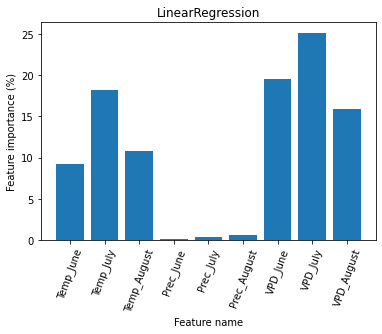

Temp_June: 9.26%
Temp_July: 18.21%
Temp_August: 10.79%
Prec_June: 0.09%
Prec_July: 0.32%
Prec_August: 0.59%
VPD_June: 19.59%
VPD_July: 25.21%
VPD_August: 15.94%


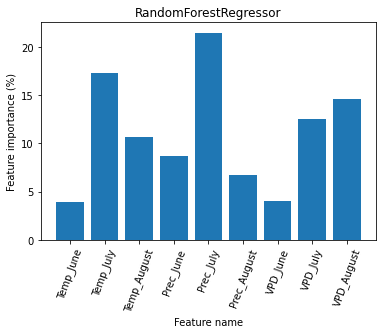

Temp_June: 3.90%
Temp_July: 17.31%
Temp_August: 10.62%
Prec_June: 8.71%
Prec_July: 21.50%
Prec_August: 6.74%
VPD_June: 4.07%
VPD_July: 12.50%
VPD_August: 14.66%


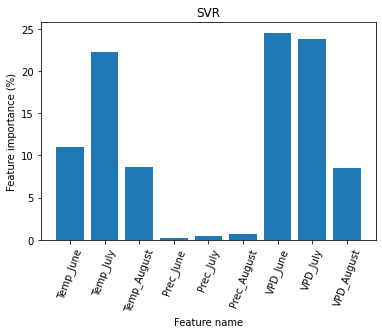

Temp_June: 10.95%
Temp_July: 22.31%
Temp_August: 8.62%
Prec_June: 0.20%
Prec_July: 0.41%
Prec_August: 0.64%
VPD_June: 24.57%
VPD_July: 23.83%
VPD_August: 8.47%


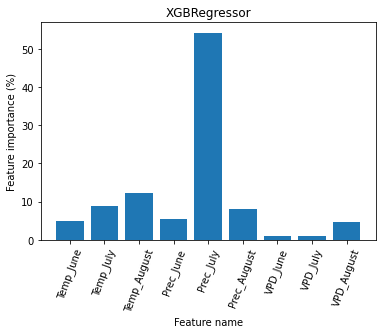

Temp_June: 4.95%
Temp_July: 8.80%
Temp_August: 12.32%
Prec_June: 5.37%
Prec_July: 54.22%
Prec_August: 7.97%
VPD_June: 1.01%
VPD_July: 0.87%
VPD_August: 4.50%


,R2,R,P-value
Model,,,
LinearRegression,-0.344630,0.343133,0.193214
RandomForestRegressor,-0.121568,0.468502,0.067193
SVR,-0.201552,0.472970,0.064277
XGBRegressor,-0.309729,0.545081,0.028994


In [63]:
train_models(trn, trg)

# Taymyr -- Khatanga

In [64]:
TAY_cleared = TAY.dropna()
parameters = ['Temp_June', 'Temp_July', 'Temp_August', 'Prec_June', 'Prec_July', 'Prec_August', 'VPD_June', 'VPD_July', 'VPD_August']
trg = TAY_cleared[['d18O_TAY']]
trn = TAY_cleared.drop(['Year','d18O_TAY'], axis=1)

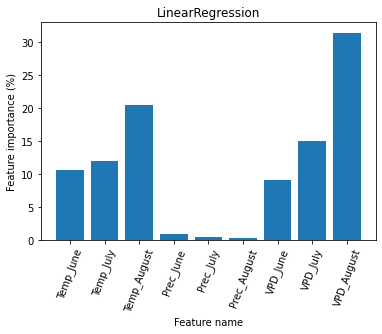

Temp_June: 10.59%
Temp_July: 11.98%
Temp_August: 20.35%
Prec_June: 0.92%
Prec_July: 0.44%
Prec_August: 0.31%
VPD_June: 9.08%
VPD_July: 14.92%
VPD_August: 31.40%


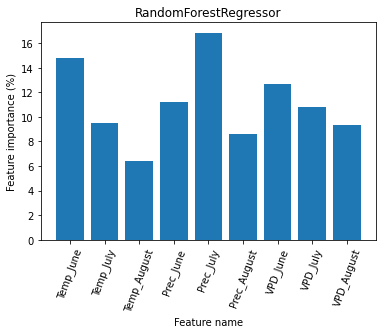

Temp_June: 14.79%
Temp_July: 9.47%
Temp_August: 6.41%
Prec_June: 11.18%
Prec_July: 16.84%
Prec_August: 8.59%
VPD_June: 12.65%
VPD_July: 10.76%
VPD_August: 9.31%


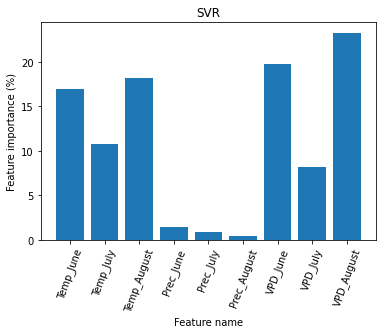

Temp_June: 16.95%
Temp_July: 10.79%
Temp_August: 18.25%
Prec_June: 1.46%
Prec_July: 0.84%
Prec_August: 0.37%
VPD_June: 19.83%
VPD_July: 8.20%
VPD_August: 23.32%


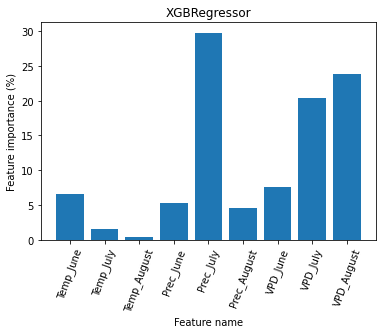

Temp_June: 6.56%
Temp_July: 1.59%
Temp_August: 0.38%
Prec_June: 5.22%
Prec_July: 29.81%
Prec_August: 4.58%
VPD_June: 7.62%
VPD_July: 20.43%
VPD_August: 23.81%


,R2,R,P-value
Model,,,
LinearRegression,-3.659939,-0.119886,0.635618
RandomForestRegressor,-0.111601,0.157840,0.531629
SVR,-1.512127,-0.161606,0.521751
XGBRegressor,-1.055862,-0.011454,0.964021


In [65]:
train_models(trn, trg)

# Canada -- Inuvik

In [67]:
CAN_cleared = CAN.dropna()
parameters = ['Temp_June', 'Temp_July', 'Temp_August', 'Prec_June', 'Prec_July', 'Prec_August', 'VPD_June', 'VPD_July', 'VPD_August',
              'Temp_March', 'Temp_April', 'Temp_May', 'Prec_March', 'Prec_April', 'Prec_May', 'VPD_March', 'VPD_April', 'VPD_May']
trg = CAN_cleared[['d18O_CAN']]
trn = CAN_cleared.drop(['Year','d18O_CAN'], axis=1)

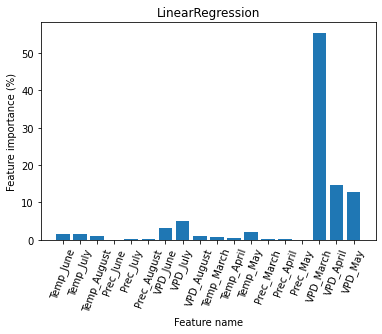

Temp_June: 1.51%
Temp_July: 1.48%
Temp_August: 1.05%
Prec_June: 0.03%
Prec_July: 0.07%
Prec_August: 0.09%
VPD_June: 3.06%
VPD_July: 5.06%
VPD_August: 0.86%
Temp_March: 0.84%
Temp_April: 0.51%
Temp_May: 1.93%
Prec_March: 0.11%
Prec_April: 0.23%
Prec_May: 0.05%
VPD_March: 55.44%
VPD_April: 14.77%
VPD_May: 12.90%


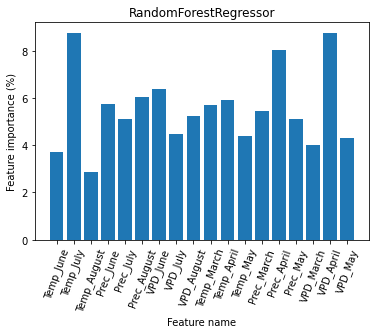

Temp_June: 3.71%
Temp_July: 8.77%
Temp_August: 2.86%
Prec_June: 5.73%
Prec_July: 5.10%
Prec_August: 6.04%
VPD_June: 6.38%
VPD_July: 4.46%
VPD_August: 5.25%
Temp_March: 5.71%
Temp_April: 5.92%
Temp_May: 4.38%
Prec_March: 5.46%
Prec_April: 8.03%
Prec_May: 5.11%
VPD_March: 3.99%
VPD_April: 8.77%
VPD_May: 4.32%


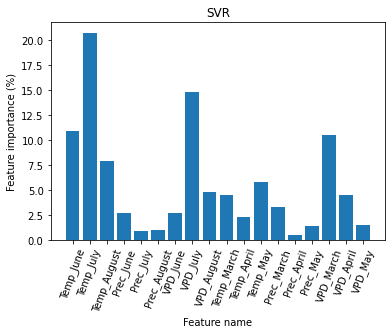

Temp_June: 10.85%
Temp_July: 20.71%
Temp_August: 7.87%
Prec_June: 2.70%
Prec_July: 0.87%
Prec_August: 0.94%
VPD_June: 2.70%
VPD_July: 14.74%
VPD_August: 4.78%
Temp_March: 4.43%
Temp_April: 2.26%
Temp_May: 5.74%
Prec_March: 3.27%
Prec_April: 0.44%
Prec_May: 1.37%
VPD_March: 10.45%
VPD_April: 4.44%
VPD_May: 1.45%


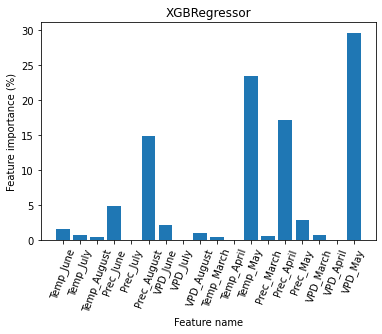

Temp_June: 1.50%
Temp_July: 0.72%
Temp_August: 0.43%
Prec_June: 4.77%
Prec_July: 0.00%
Prec_August: 14.90%
VPD_June: 2.14%
VPD_July: 0.00%
VPD_August: 1.01%
Temp_March: 0.35%
Temp_April: 0.00%
Temp_May: 23.44%
Prec_March: 0.48%
Prec_April: 17.13%
Prec_May: 2.78%
VPD_March: 0.69%
VPD_April: 0.00%
VPD_May: 29.65%


,R2,R,P-value
Model,,,
LinearRegression,-10.266859,-0.204105,0.483982
RandomForestRegressor,0.112664,0.397954,0.158777
SVR,-1.327293,0.092211,0.753885
XGBRegressor,-0.470390,0.041365,0.888342


In [68]:
train_models(trn, trg)